---
title: Statistical analysis
description: Exploratory Data Analysis of Head Coaches and Match Results datasets
---

### Imports

In [41]:
import pandas as pd
import numpy as np
from utils.plotting import *
from scipy.stats import pearsonr

### Loading data

In [42]:
head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['Appointed', 'EndDate'])
head_coach = head_coach[head_coach['Tenure'] <= 3000]
# head_coach = head_coach[head_coach['Tenure'] >= 0]

In [43]:
# Plot of wins, draw and losses percentage over days in post
head_coach['WinPercentage'] = head_coach['Wins'] / head_coach['Matches'] * 100
head_coach['DrawPercentage'] = head_coach['Draws'] / head_coach['Matches'] * 100
head_coach['LossPercentage'] = head_coach['Losses'] / head_coach['Matches'] * 100

def plot_percentage_over_days(data, y_value, y_leg, color):
    plt.figure()
    sns.regplot(x='Tenure', y=y_value, data=data, color=sns.light_palette(color, as_cmap=True)(0.4), scatter_kws={'alpha':0.5}, label = y_leg + ' ratio')
    
    plt.title(f'{y_leg} ratio of Head Coaches appointments over Head Coaches tenure in club')
    ## x = head coach tenure in a club
    ## y = win/draw/loss ratio under the appointment of the head coach
    plt.xlabel('Head Coach tenure (days)')
    plt.ylabel(f'{y_leg.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    # Calculate Pearson correlation coefficient
    r, p = pearsonr(data['Tenure'], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')
    
    # plt.savefig(f'figures/{y_value}_over_hc_tenure.png')

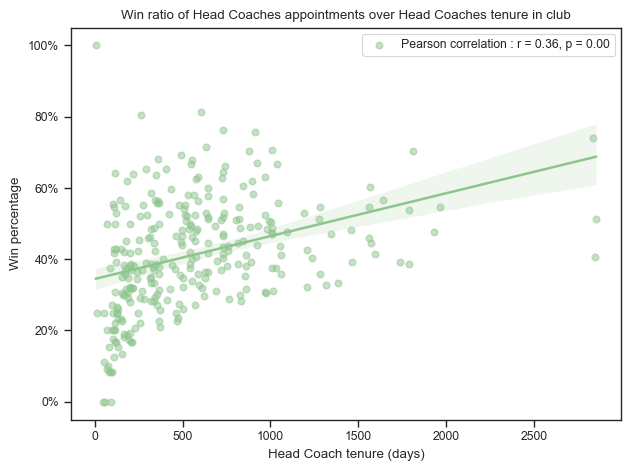

In [44]:
#| label: hc_win_ratio_over_days
plot_percentage_over_days(head_coach, 'WinPercentage', 'Win', 'green')

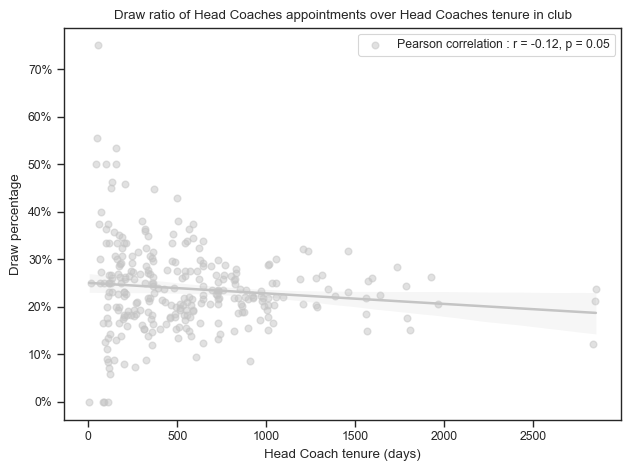

In [45]:
#| label: hc_draw_ratio_over_days
plot_percentage_over_days(head_coach, 'DrawPercentage', 'Draw', 'gray')

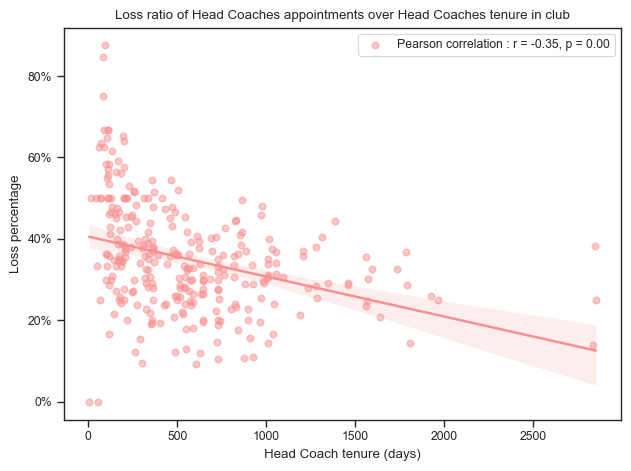

In [46]:
#| label: hc_loss_ratio_over_days
plot_percentage_over_days(head_coach, 'LossPercentage', 'Loss', 'red')

In [47]:
# Plot match outcome of clubs over number of coach seen by club

club_results = head_coach.groupby('Team').agg({'Wins': 'sum', 'Draws': 'sum', 'Losses': 'sum', 'Matches': 'sum', 'HeadCoach': 'count'})
club_results = club_results.rename(columns={'HeadCoach': 'CoachCount'})
club_results['WinPercentage'] = club_results['Wins'] / club_results['Matches'] * 100
club_results['DrawPercentage'] = club_results['Draws'] / club_results['Matches'] * 100
club_results['LossPercentage'] = club_results['Losses'] / club_results['Matches'] * 100

# Plot percentage over number of coach seen by club
def plot_club_outcome(data, y_value, y_leg, color):
    plt.figure()
    sns.regplot(x='CoachCount', y=y_value, data=data, color=sns.light_palette(color, as_cmap=True)(0.4), scatter_kws={'alpha':0.5}, label = y_leg + ' ratio')
    # x = number of coach seen by club
    # y = win/draw/loss ratio of the club
    plt.title(f'{y_leg} ratio of clubs over the number of Head Coaches teams had between xx and xx')
    plt.xlabel('Number of coach seen by club')
    plt.ylabel(f'{y_leg} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    r, p = pearsonr(data['CoachCount'], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')
    
    # plt.savefig(f'figures/{y_value}_over_club_hc_count.png')

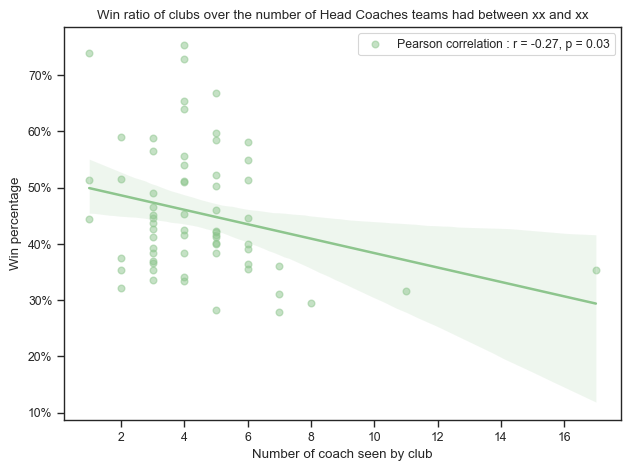

In [48]:
#| label: club_win_ratio_over_coach_count
plot_club_outcome(club_results, 'WinPercentage', 'Win', 'green')

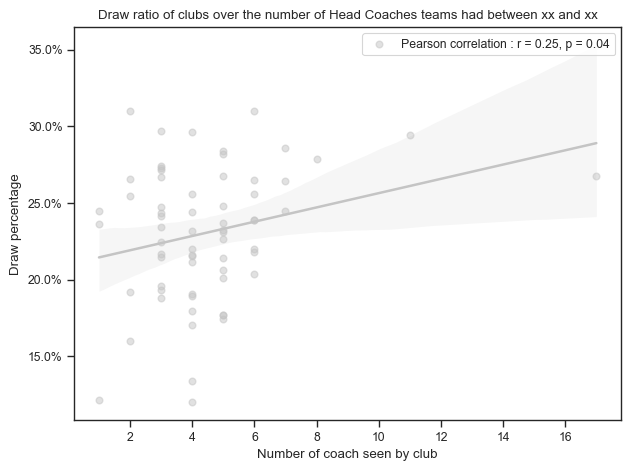

In [49]:
#| label: club_draw_ratio_over_coach_count
plot_club_outcome(club_results, 'DrawPercentage', 'Draw', 'gray')

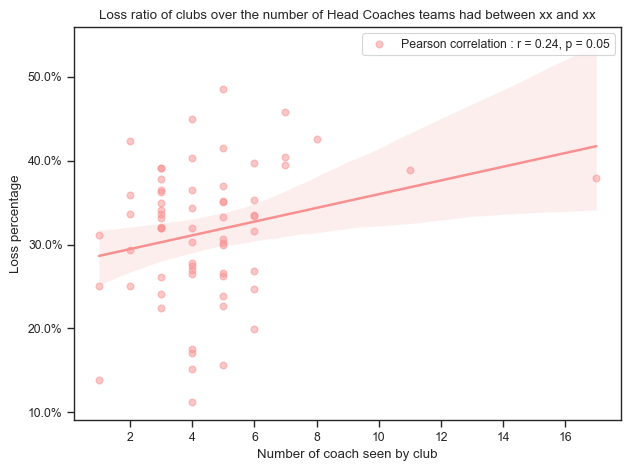

In [50]:
#| label: club_loss_ratio_over_coach_count
plot_club_outcome(club_results, 'LossPercentage', 'Loss', 'red')

In [51]:
# Plot of wins, draw and losses percentage over number of club head coach has been

head_coach_performance = head_coach.groupby('HeadCoach').agg({'Matches': 'sum', 'Wins': 'sum', 'Draws': 'sum', 'Losses': 'sum', 'Team': 'count'}).reset_index()
head_coach_performance = head_coach_performance.rename(columns={'Team': 'ClubCount'})
head_coach_performance['WinPercentage'] = head_coach_performance['Wins'] / head_coach_performance['Matches'] * 100
head_coach_performance['DrawPercentage'] = head_coach_performance['Draws'] / head_coach_performance['Matches'] * 100
head_coach_performance['LossPercentage'] = head_coach_performance['Losses'] / head_coach_performance['Matches'] * 100

# Linear regression plot for wins, draw and losses percentage over number of club head coach has been

def plot_percentage_over_club_count(data, y_value, y_leg, color):
    plt.figure()
    sns.regplot(x='ClubCount', y=y_value, data=data, color = sns.light_palette(color, as_cmap=True)(0.4), scatter_kws={'alpha':0.5}, label = y_leg + ' ratio')
    # x = number of club head coach has worked for
    # y = win/draw/loss ratio of the head coach over all clubs
    plt.title(f'{y_leg.capitalize()} ratio of Head Coaches over number of clubs Head Coaches worked for')
    plt.xticks(range(1, data['ClubCount'].max() + 1))
    plt.xlabel('Number of clubs Head Coach have worked for')
    plt.ylabel(f'{y_leg.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    r, p = pearsonr(data['ClubCount'], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')
    
    # plt.savefig(f'figures/{y_value}_over_club_per_hc_count.png')

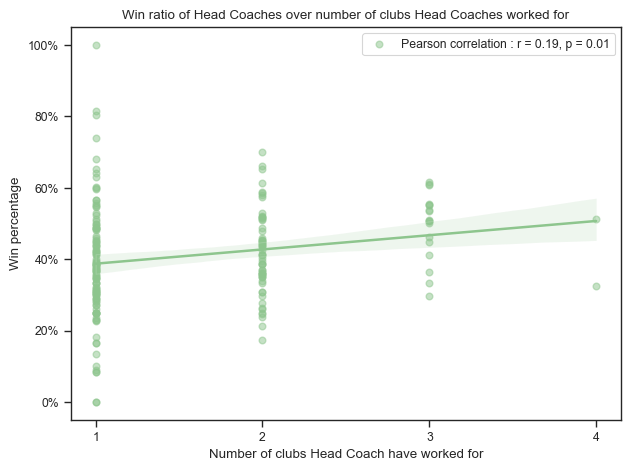

In [52]:
#| label: hc_win_ratio_over_club_count
plot_percentage_over_club_count(head_coach_performance, 'WinPercentage', 'win', 'green')


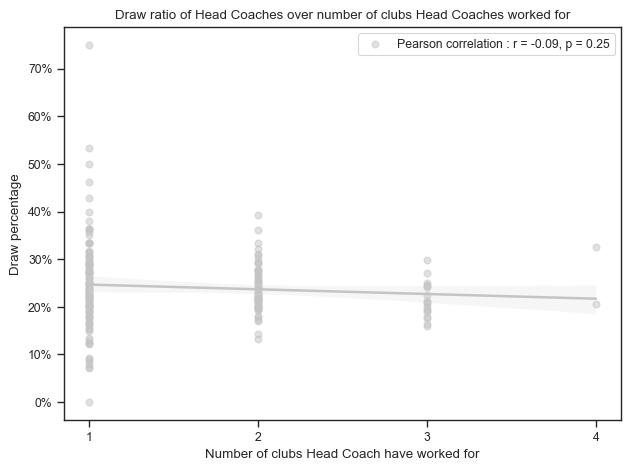

In [53]:
#| label: hc_draw_ratio_over_club_count
plot_percentage_over_club_count(head_coach_performance, 'DrawPercentage', 'draw', 'gray')

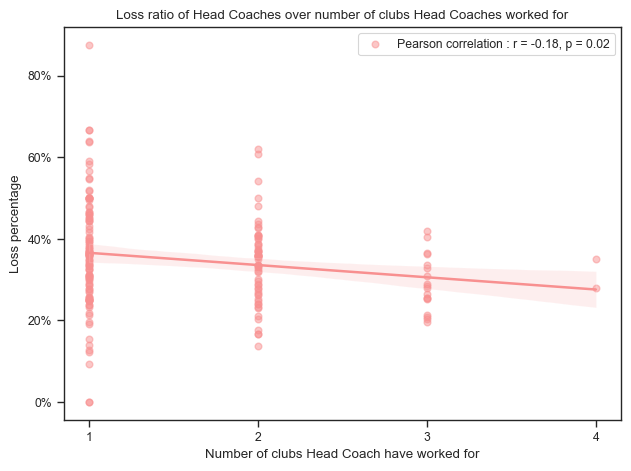

In [54]:
#| label: hc_loss_ratio_over_club_count
plot_percentage_over_club_count(head_coach_performance, 'LossPercentage', 'loss', 'red')

### Loading data

In [55]:
#| label: joint_data
match_results = pd.read_csv('data/match_results.csv', parse_dates=['Date'])
match_results.head()

,League,Country,Date,Team,Goals,Result,isHome,HeadCoach,DaysInPost
0,Premier League,England,2017-08-11,Arsenal,4.0,win,True,Arsène Wenger,7619.0
1,Premier League,England,2017-08-12,Chelsea,2.0,loss,True,Antonio Conte,407.0
2,Premier League,England,2017-08-12,Brighton,0.0,loss,True,Chris Hughton,955.0
3,Premier League,England,2017-08-13,Newcastle Utd,0.0,loss,True,Rafael Benítez,520.0
4,Premier League,England,2017-08-13,Manchester Utd,4.0,win,True,José Mourinho,408.0


In [56]:
match_results['Win'] = match_results['Result'].apply(lambda x: 1 if x == 'win' else 0)
match_results['Loss'] = match_results['Result'].apply(lambda x: 1 if x == 'loss' else 0)
match_results['Draw'] = match_results['Result'].apply(lambda x: 1 if x == 'draw' else 0)

# Exclude rows where don't have information about head coach days in post during match
match_results = match_results[~match_results['DaysInPost'].isna()]

In [57]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def plot_match_outcome_over_coach_tenure(data, y_value, y_label, color):
    # Create a jointplot
    # g = sns.jointplot(data=data, x='days_in_post', y=y_value, kind='reg', ratio = 3, marginal_ticks = False)
    g = sns.jointplot(data=data, x='DaysInPost', y=y_value, kind='reg', 
                      scatter_kws={'alpha':0.5, 'color': sns.light_palette(color, as_cmap=True)(0.4)}, 
                      line_kws={'color': sns.light_palette(color, as_cmap=True)(0.4)}, 
                      ratio = 3, marginal_ticks = False)
    g.figure.set_figwidth(6)
    g.figure.set_figheight(2)
    g.figure.suptitle(f'Match outcome over Head Coach tenure', x = 0.4, y = 1.1)
    g.set_axis_labels('Head Coach Tenure', 'Match Outcome')
    
    # Legend
    r, p = pearsonr(data['DaysInPost'], data[y_value])
    legend = g.ax_joint.legend([f'r = {r:.2f}, p = {p:.2f}'], loc='upper left', bbox_to_anchor=(1, 1.6))
    legend.set_title("Pearson correlation")
    
    # Set y-axis tick
    g.ax_joint.set_yticks([0, 1])
    g.ax_joint.set_yticklabels(['not ' + y_label, y_label])
    # Save the figure
    # g.savefig(f'figures/{y_value}_over_coach_tenure.png')

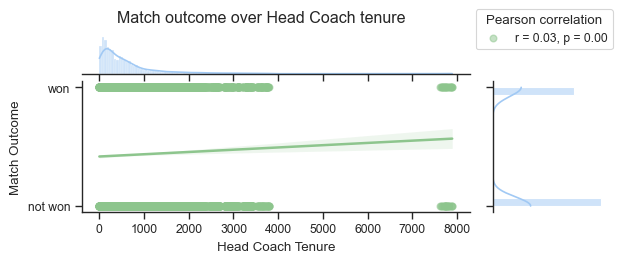

In [58]:
#| label: win_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, 'Win', 'won', 'green')


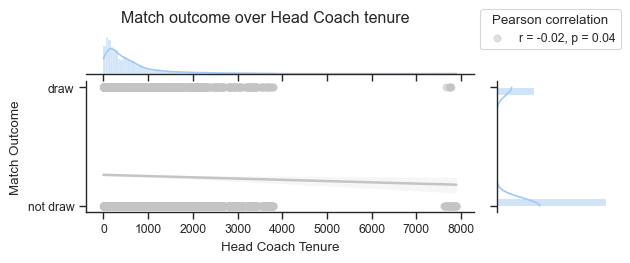

In [59]:
#| label: draw_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, 'Draw', 'draw', 'gray')

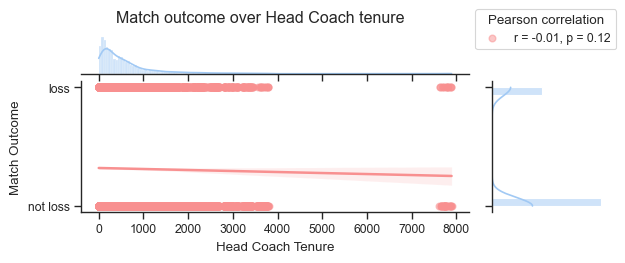

In [60]:
#| label: loss_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, 'Loss', 'loss', 'red')

In [61]:
match_results_bis = match_results[match_results['DaysInPost'] < 2000]
match_results_bis = match_results_bis.groupby('DaysInPost').agg({'Win': 'mean', 'Draw': 'mean', 'Loss': 'mean', 'Result': 'count'})
match_results_bis.columns = ['WinRate', 'DrawRate', 'LossRate', 'MatchCount']
# Add missing days between the first and last day
match_results_bis = match_results_bis.reindex(range(int(min(match_results_bis.index)), int(max(match_results_bis.index) + 1)), fill_value=0)

def weighted_rolling_mean(data, weights, window_size=50):
    def weighted_mean(x):
        return np.average(data.loc[x.index], weights=weights.loc[x.index])

    return data.rolling(window_size, min_periods=1).apply(weighted_mean, raw=False)

match_results_bis['WinRateRA'] = weighted_rolling_mean(match_results_bis['WinRate'], match_results_bis['MatchCount'])
match_results_bis['DrawRateRA'] = weighted_rolling_mean(match_results_bis['DrawRate'], match_results_bis['MatchCount'])
match_results_bis['LossRateRA'] = weighted_rolling_mean(match_results_bis['LossRate'], match_results_bis['MatchCount'])

# Ensures it sums to 1
(match_results_bis['WinRateRA'] + match_results_bis['DrawRateRA'] + match_results_bis['LossRateRA']).value_counts()

1.0    1890
1.0     110
Name: count, dtype: int64

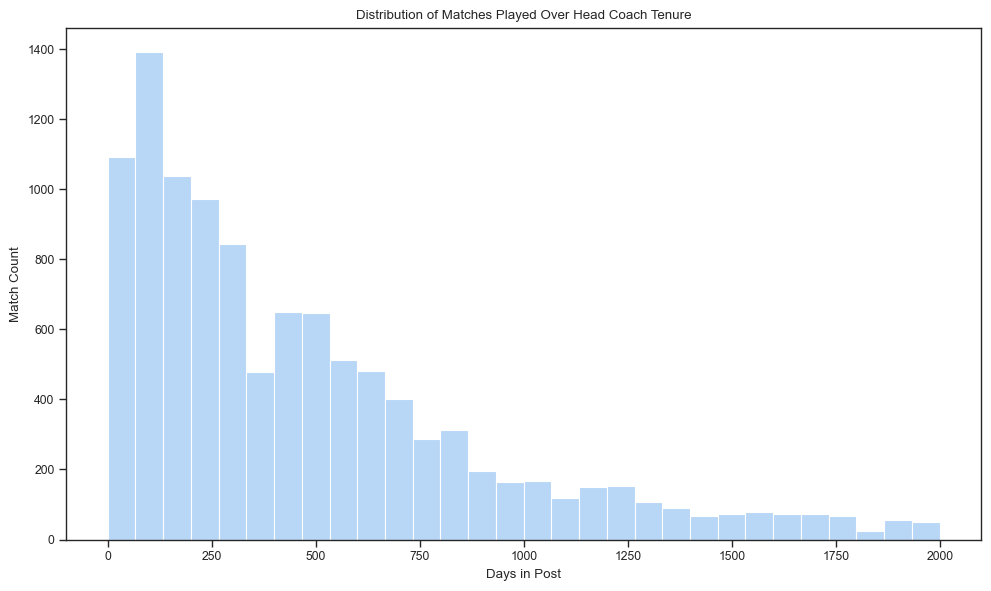

In [62]:
#| label: match_distribution_over_coach_tenure
# Create a histogram of 'match_count' over 'days_in_post'
plt.figure(figsize=(10, 6))
sns.histplot(data=match_results_bis, x='DaysInPost', weights='MatchCount', bins=30)
plt.xlabel('Days in Post')
plt.ylabel('Match Count')
plt.title('Distribution of Matches Played Over Head Coach Tenure')
plt.show()

In [63]:
def plot_proportion_over_coach_tenure(data):
    # Create a figure
    plt.figure(figsize=(8, 4))

    plt.stackplot(data.index, data['WinRateRA'], data['DrawRateRA'], data['LossRateRA'], labels=['Win', 'Draw', 'Loss'], colors=['green', 'gray', 'red'], alpha=0.5)

    # Add legend and labels
    plt.legend(loc='upper left')
    plt.xlabel('Head Coach Tenure')
    plt.ylabel('Proportion of Match Outcome')
    plt.title('Proportion of Match Outcome Over Head Coach Tenure (30-day weighted rolling average)')

    # Save the figure
    # plt.savefig('figures/proportion_over_coach_tenure.png')
    plt.show()

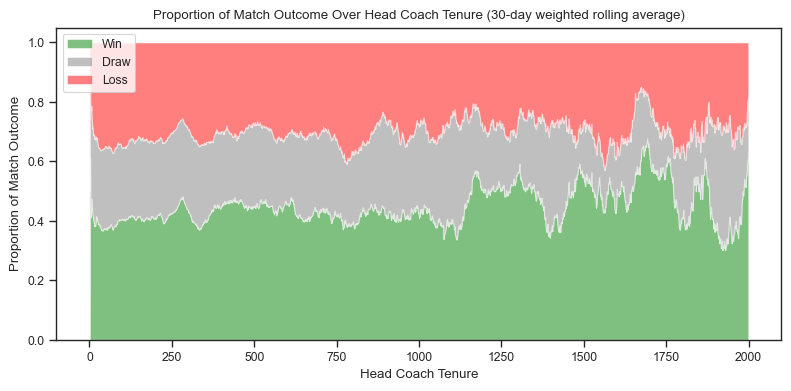

In [64]:
#| label: match_outcome_over_coach_tenure
plot_proportion_over_coach_tenure(match_results_bis)